#### **PREPROCESADO COMPLETO: Limpieza de ruido, silencio, pre-énfasis**

In [17]:
import numpy as np
import librosa
import os
import librosa.display
from scipy.signal import butter, filtfilt
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display
try:
    import noisereduce as nr
    _HAS_NOISEREDUCE = True
except ImportError:
    _HAS_NOISEREDUCE = False

In [18]:
def butter_bandpass(lowcut: float, highcut: float, fs: int, order: int = 4):
    """
    Diseña un filtro Butterworth pasa-banda.

    Parámetros:
    - lowcut: frecuencia de corte baja en Hz.
    - highcut: frecuencia de corte alta en Hz.
    - fs: frecuencia de muestreo en Hz.
    - order: orden del filtro (defecto=4).

    Retorna:
    - b, a: coeficientes del filtro.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def bandpass_filter(y: np.ndarray, sr: int,
                    lowcut: float = 300.0,
                    highcut: float = 3400.0,
                    order: int = 4) -> np.ndarray:
    """
    Aplica un filtro pasa-banda para conservar sólo la banda de voz.

    Parámetros:
    - y: señal de audio (1D numpy array).
    - sr: frecuencia de muestreo en Hz.
    - lowcut, highcut: límites de frecuencia en Hz.
    - order: orden del filtro.

    Retorna:
    - Señal filtrada.
    """
    b, a = butter_bandpass(lowcut, highcut, sr, order)
    return filtfilt(b, a, y)


def pre_emphasis(y: np.ndarray, coef: float = 0.97) -> np.ndarray:
    """
    Aplica filtro de pre-énfasis para realzar frecuencias altas.

    Fórmula:
        y[n] = x[n] - coef * x[n-1]

    Parámetros:
    - y: señal mono (1D numpy array).
    - coef: coeficiente de pre-énfasis (defecto=0.97).

    Retorna:
    - Señal con pre-énfasis aplicada.
    """
    return np.append(y[0], y[1:] - coef * y[:-1])


def normalize_peak(y: np.ndarray) -> np.ndarray:
    """
    Normalización por pico: escala la señal para que su amplitud máxima sea 1.

    Parámetros:
    - y: señal de audio.

    Retorna:
    - Señal normalizada.
    """
    peak = np.max(np.abs(y))
    return y / peak if peak > 0 else y


def normalize_rms(y: np.ndarray, target_rms: float = 0.1) -> np.ndarray:
    """
    Normalización RMS: ajusta la señal para que su RMS coincida con target_rms.

    Parámetros:
    - y: señal de audio.
    - target_rms: RMS objetivo (defecto=0.1).

    Retorna:
    - Señal normalizada.
    """
    rms = np.sqrt(np.mean(y**2))
    return y * (target_rms / rms) if rms > 0 else y


def frame_signal(y: np.ndarray, sr: int,
                 frame_length: int = None,
                 hop_length: int = None) -> np.ndarray:
    """
    Divide la señal en frames de tamaño fijo.

    Parámetros:
    - y: señal de audio.
    - sr: frecuencia de muestreo.
    - frame_length: tamaño del frame en muestras (defecto 25 ms).
    - hop_length: salto entre frames en muestras (defecto 10 ms).

    Retorna:
    - Matriz de shape (n_frames, frame_length).
    """
    if frame_length is None:
        frame_length = int(0.025 * sr)
    if hop_length is None:
        hop_length = int(0.010 * sr)
    num_frames = 1 + (len(y) - frame_length) // hop_length
    frames = np.lib.stride_tricks.as_strided(
        y,
        shape=(num_frames, frame_length),
        strides=(y.strides[0] * hop_length, y.strides[0])
    )
    return frames


def apply_window(frames: np.ndarray, window_fn=np.hamming) -> np.ndarray:
    """
    Aplica ventana de suavizado a cada frame para reducir leakage.

    Parámetros:
    - frames: matriz (n_frames, frame_length).
    - window_fn: función de ventana (defecto np.hamming).

    Retorna:
    - Frames aplicando la ventana.
    """
    win = window_fn(frames.shape[1])
    return frames * win[None, :]


def reduce_noise(y: np.ndarray, sr: int, prop_decrease: float = 1.0) -> np.ndarray:
    """
    Realiza reducción de ruido por spectral gating usando noisereduce.

    Parámetros:
    - y: señal de audio.
    - sr: frecuencia de muestreo.
    - prop_decrease: proporción de reducción (0 a 1).

    Retorna:
    - Señal con ruido reducido.

    Nota: requiere instalar noisereduce (pip install noisereduce).
    """
    if not _HAS_NOISEREDUCE:
        raise ImportError("Para usar reduce_noise instala la librería noisereduce.")
    return nr.reduce_noise(y=y, sr=sr, prop_decrease=prop_decrease)

def plot_waveform(y: np.ndarray, sr: int, title: str):
    """
    Grafica la forma de onda (waveform) de la señal de audio.
    
    Parámetros:
    - y: señal de audio (1D numpy array).
    - sr: frecuencia de muestreo.
    - title: título para el gráfico.
    """
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.show()

def plot_spectrogram(y: np.ndarray, sr: int, title: str):
    """
    Grafica el espectrograma (espectrograma logarítmico).
    
    Parámetros:
    - y: señal de audio (1D numpy array).
    - sr: frecuencia de muestreo.
    - title: título para el gráfico.
    """
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.show()

def preprocess_audio(path: str,
                     sr: int = 16000,
                     trim_db: float = 20.0,
                     lowcut: float = 300.0,
                     highcut: float = 3400.0,
                     pre_coef: float = 0.97,
                     rms_target: float = 0.1,
                     reduce_noise_flag: bool = False) -> np.ndarray:
    """
    Pipeline completo de preprocesado de audio:
    1) Carga y conversión a mono.
    2) (Opcional) Reducción de ruido.
    3) Recorte de silencio inicial y final.
    4) Pre-énfasis.
    5) Filtro pasa-banda para voz.
    6) Normalización por RMS.

    Parámetros:
    - path: ruta al archivo de audio.
    - sr: frecuencia de muestreo deseada.
    - trim_db: umbral dB para recorte de silencio.
    - lowcut, highcut: límites de frecuencia para filtrado.
    - pre_coef: coeficiente de pre-énfasis.
    - rms_target: RMS objetivo para normalización.
    - reduce_noise_flag: activar reducción de ruido.

    Retorna:
    - Señal procesada lista para extracción de features.
    """

    # 1) Carga
    y, _ = librosa.load(path, sr=sr, mono=True)
    
    # Mostrar audio original
    print("Reproduciendo audio original...")
    display(Audio(y, rate=sr))
    plot_waveform(y, sr, "Waveform original")
    plot_spectrogram(y, sr, "Espectrograma original")

    # 2) Reducción de ruido si se solicita
    if reduce_noise_flag:
        print("Aplicando reducción de ruido...")
        y = reduce_noise(y, sr)
        display(Audio(y, rate=sr))
        plot_waveform(y, sr, "Waveform después de reducción de ruido")
        plot_spectrogram(y, sr, "Espectrograma después de reducción de ruido")

    # 3) Recorte de silencio
    print("Aplicando recorte de silencio...")
    y, _ = librosa.effects.trim(y, top_db=trim_db)
    display(Audio(y, rate=sr))
    plot_waveform(y, sr, "Waveform después de recorte de silencio")
    plot_spectrogram(y, sr, "Espectrograma después de recorte de silencio")

    # 4) Pre-énfasis
    print("Aplicando pre-énfasis...")
    y = pre_emphasis(y, coef=pre_coef)
    display(Audio(y, rate=sr))
    plot_waveform(y, sr, "Waveform después de pre-énfasis")
    plot_spectrogram(y, sr, "Espectrograma después de pre-énfasis")

    # 5) Filtrado pasa-banda
    print("Aplicando filtro pasa-banda...")
    y = bandpass_filter(y, sr, lowcut, highcut)
    display(Audio(y, rate=sr))
    plot_waveform(y, sr, "Waveform después de filtro pasa-banda")
    plot_spectrogram(y, sr, "Espectrograma después de filtro pasa-banda")

    # 6) Normalización RMS
    print("Aplicando normalización RMS...")
    y = normalize_rms(y, target_rms=rms_target)
    display(Audio(y, rate=sr))
    plot_waveform(y, sr, "Waveform después de normalización RMS")
    plot_spectrogram(y, sr, "Espectrograma después de normalización RMS")

    return y

Reproduciendo audio original...


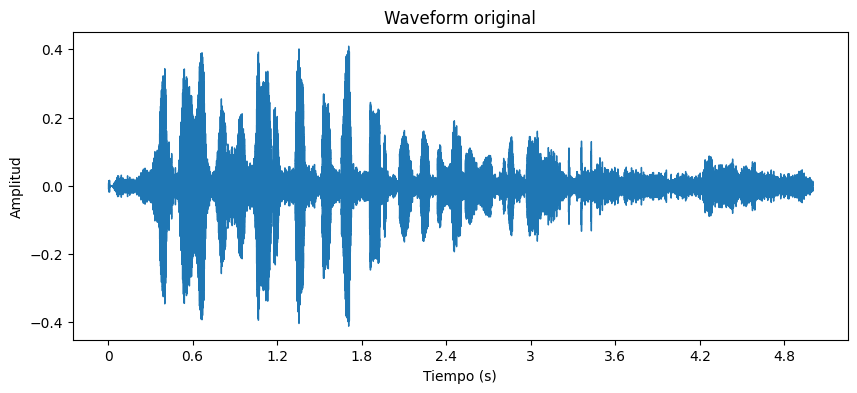

C:\Users\pablo\AppData\Local\Temp\ipykernel_26828\2676061156.py:174: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


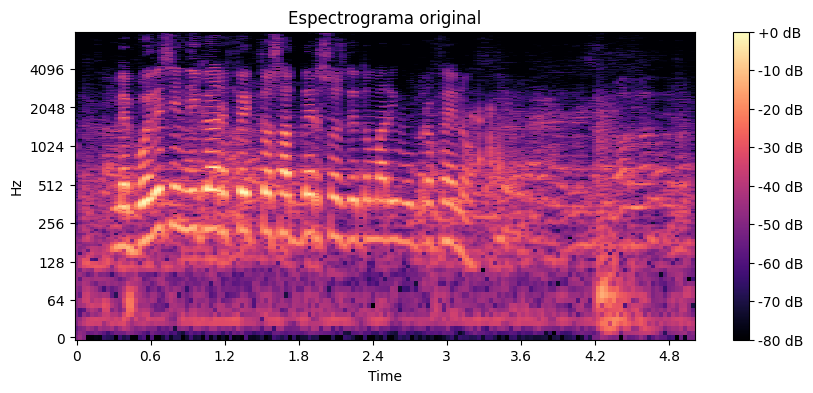

Aplicando reducción de ruido...


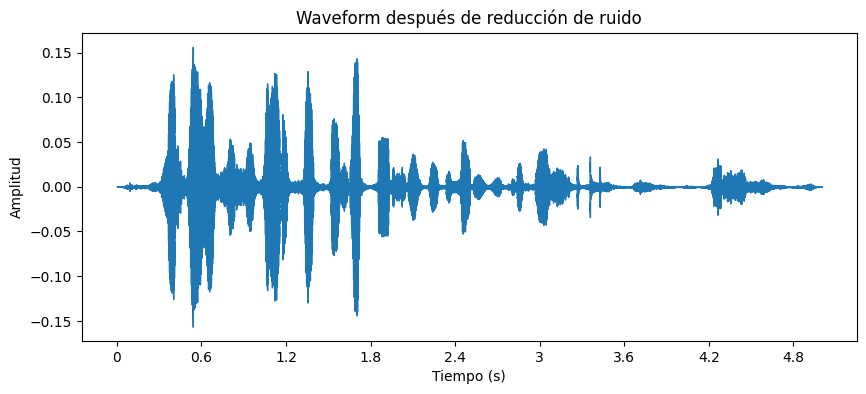

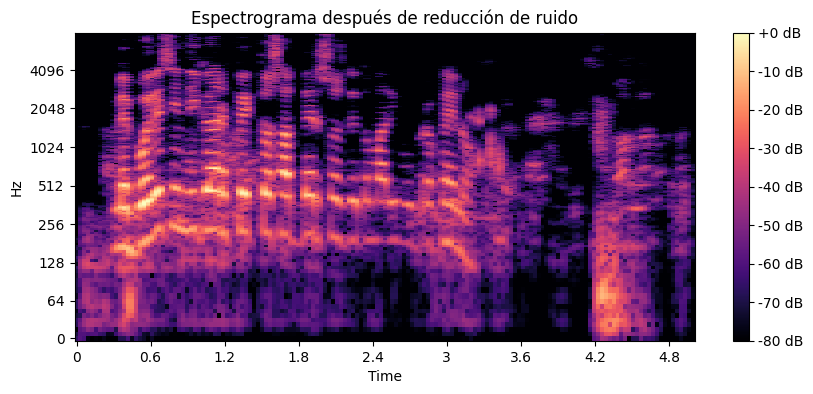

Aplicando recorte de silencio...


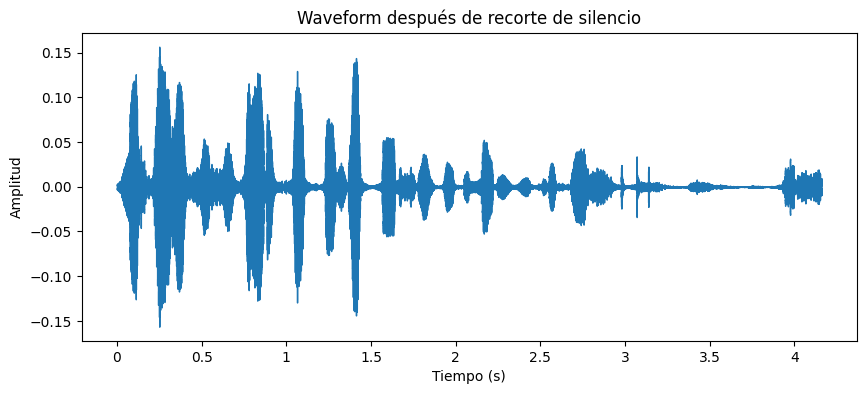

C:\Users\pablo\AppData\Local\Temp\ipykernel_26828\2676061156.py:174: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


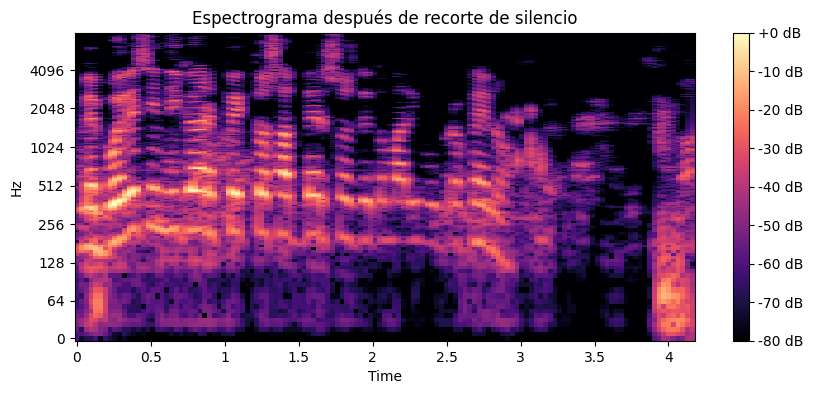

Aplicando pre-énfasis...


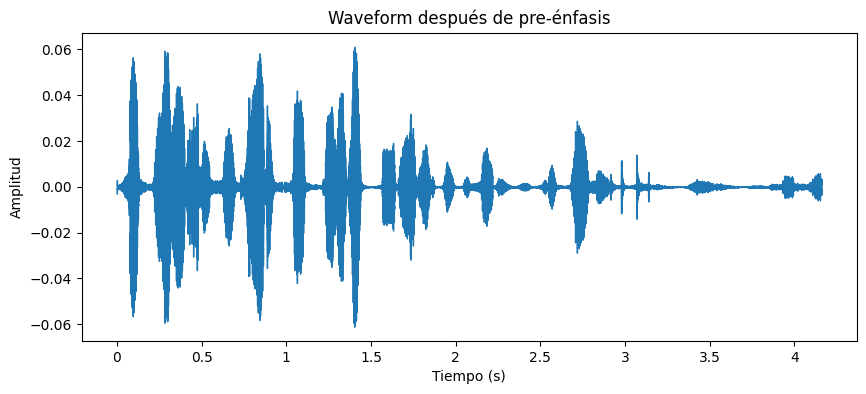

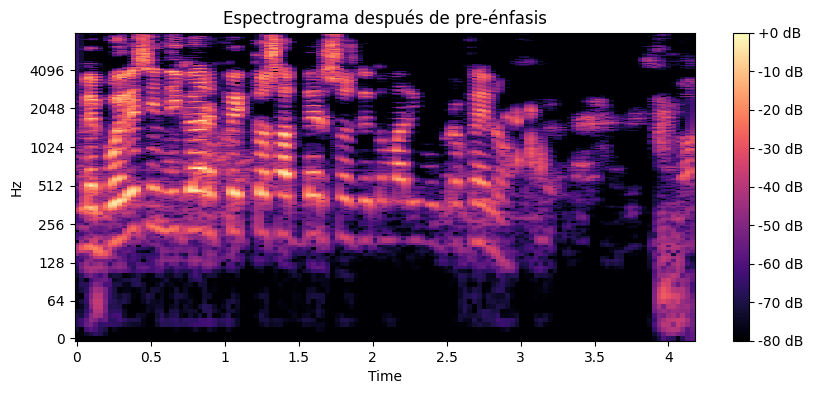

Aplicando filtro pasa-banda...


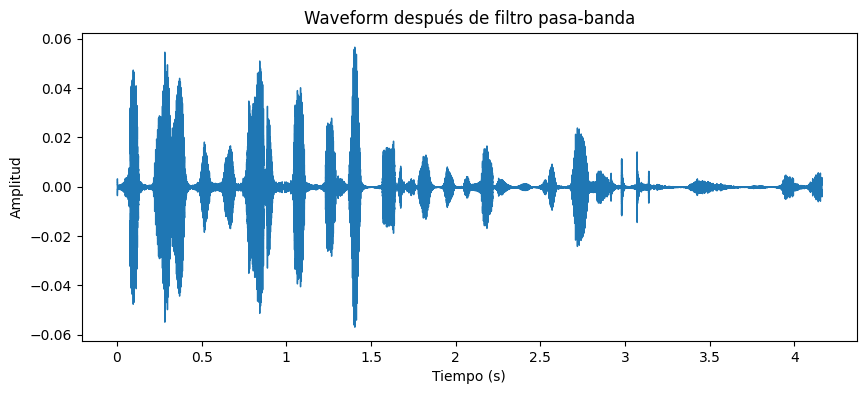

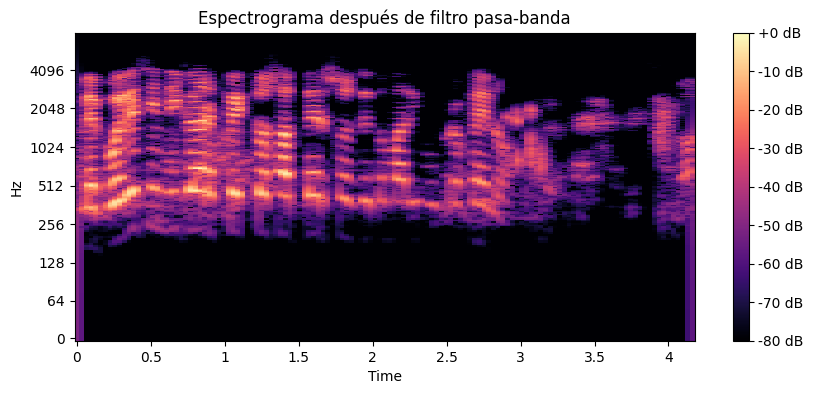

Aplicando normalización RMS...


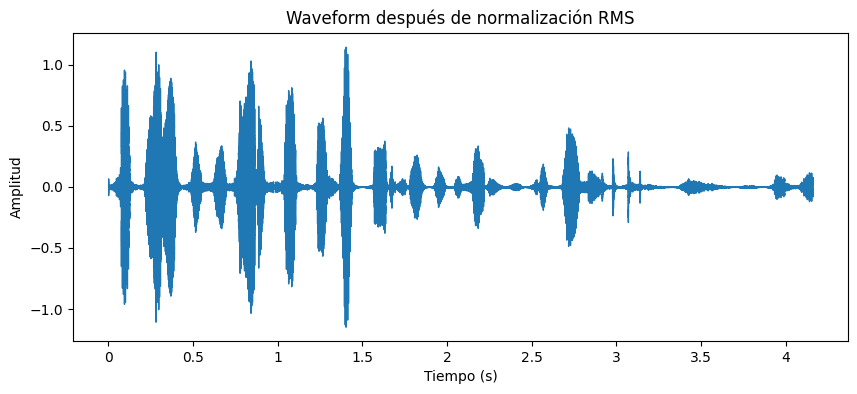

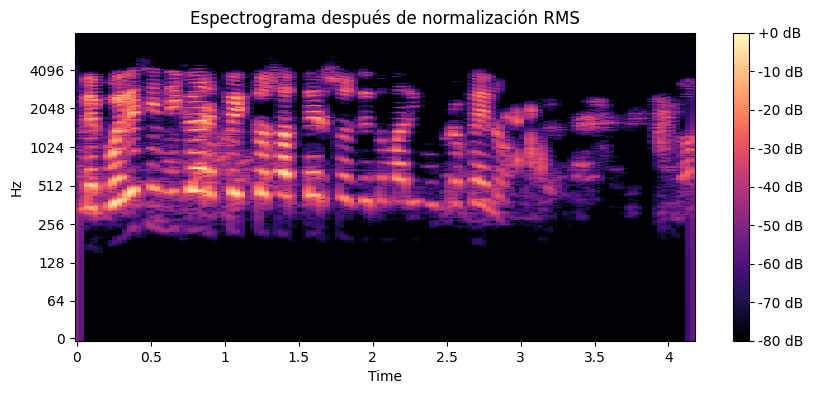

In [19]:
# Ruta al archivo de audio
audio_path = "C:\\Users\\pablo\\MBD_ICAI_repo\\MBD_ICAI\\Analisis_de_Datos_No_Estructurados_ADNoE\\PharmAI\\data\\outputs\\6_audio\\efectos_adversos\\audio_9_angel.wav"

# Preprocesar el audio
y_processed = preprocess_audio(audio_path,
                                sr=16000,
                                trim_db=20.0,
                                lowcut=300.0,
                                highcut=3400.0,
                                pre_coef=0.97,
                                rms_target=0.1,
                                reduce_noise_flag=True)